In [1]:
%matplotlib inline
import scipy
import sympy
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from modsim import*

condition = Condition(R = 51,
                      L = 4,
                      C0 = 220 * (10 ** (-3)), 
                      V0 = 5,
                      dV0dt = 0,
                      f0 = 1073.02, 
                      w0 = 1)

# Do research of temp dependance of L and C

In [2]:
duration = 120

dt = 1

ts = linrange(0, duration, dt)

In [3]:
def make_system(condition):
    
    unpack(condition)
    
    init = State(X1 = V0, X2 = dV0dt)
    
    system = System(init=init, R=R, L=L, C0=C0, V0=V0, dV0dt=dV0dt, f0=f0, w0=w0, ts=ts)
    
    return system
                    
    
circuit = make_system(condition)

In [4]:
def slope_func(state, t, circuit):
    
    X1, X2 = state
    unpack(circuit)
    
    dX1dt = X2
    # dX2dt = ((L/R*C0) * (V0*np.degrees(np.sin(w0*t))) - ((1/R*L*C0)*X1) - ((1/L)*X2))
    # Used w0 in radians to get better results
    dX2dt = ((L/R*C0) * (V0*math.sin((w0)*t)) - ((1/R*L*C0)*X1) - ((1/L)*X2)) 
    
    return dX1dt, dX2dt

slope_func(circuit.init, 0, circuit)

(0.0, -0.086274509803921567)

In [5]:
run_odeint(circuit, slope_func)

# circuit.results

In [6]:
X1 = circuit.results.X1 # voltage
X2 = circuit.results.X2 # first derivative
X3 = (X2.diff()/dt) # second derivative

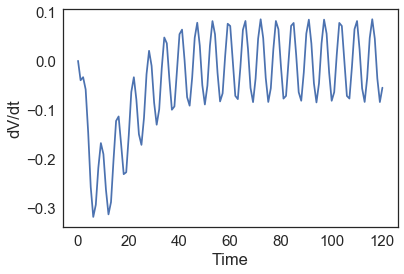

In [7]:
plt.plot(ts, X2)
xlabel("Time")
ylabel("dV/dt")

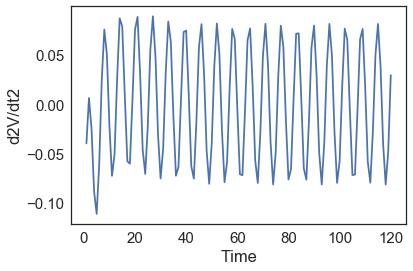

In [8]:
plt.plot(ts, X3)
xlabel("Time")
ylabel("d2V/dt2")

In [9]:
def getAmp(X3, ts):
    
    min = 10000
    max = -5
    
    for i in range(len(X3)):
        
        t = ts[i]
        x = X3[i]
        
        if t > 60 and t < 120:
            
            if x > max:
                max = x
            
            if x < min:
                min = x
                
    Amp = (max - min)
    
    return Amp    

In [10]:
getAmp(X3, ts)

0.16287243458836009

In [11]:
def run_simulation(w0):
    
    condition.w0 = w0
    #print(condition)
    
    circuit = make_system(condition)
    run_odeint(circuit, slope_func)
    X3 = (circuit.results.X2.diff()/dt)
    amp = getAmp(X3, ts)
    
    return amp
    

In [23]:
def loopy_boi():
    
    w0_array = linspace(6, 13, 75)
    amps = []
    for w0 in w0_array:
        #print(w0)
        amp = run_simulation(w0)
        amps.append(amp)
        #print(amp)
        
    return (w0_array, amps)

In [24]:
(w0_array, amp_array) = loopy_boi()
#print(w0_array)

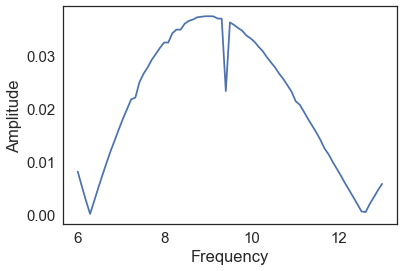

In [25]:
plt.plot(w0_array, amp_array)
#plot(w0_array, amp_array, '.')
xlabel("Frequency")
ylabel("Amplitude")
#print(amp_array)

In [15]:
w0_array[amp_array.index(0.093995685536970852)]

3.131313131313131

'When I ran ODEINT with all the values of w0, it gave me a rogue datapoint. I went in and ran ODEINT for that particular\n    datapoint and then ODEINT gave a different, valid datapoint for that particular point. So that means ODEINT is not\n    behaving properly when I run multiple iterations of w0 through it.'

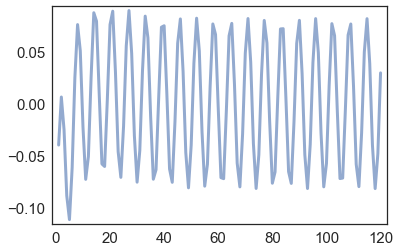

In [16]:
condition.w0 = 3.131313131313131
slope_func(circuit.init, 0, circuit)
run_odeint(circuit, slope_func)

X1 = circuit.results.X1 # voltage
X2 = circuit.results.X2 # first derivative
X3 = (X2.diff()/dt) # second derivative

plot(ts, X3)
getAmp(X3, ts)

"""When I ran ODEINT with all the values of w0, it gave me a rogue datapoint. I went in and ran ODEINT for that particular
    datapoint and then ODEINT gave a different, valid datapoint for that particular point. So that means ODEINT is not
    behaving properly when I run multiple iterations of w0 through it."""

In [17]:
# DO NOT EVER RUN THIS CELL
#goodRunW0 = w0_array
#goodRunAmp = amp_array

goodRun = pd.Series(goodRunAmp, index=goodRunW0)
goodRun.to_csv("goodrun.csv")
#plt.plot(goodRunW0, goodRunAmp)
plot(goodRun)

NameError: name 'goodRunAmp' is not defined

In [ ]:
#print(amp_array)

In [ ]:
def loopy_boi(condition, system, slope_func):
    
    w0_array = linrange(1, 2, 10)

    w0_frame = []

    for w0 in w0_array:

        #condition = Condition(R = 51, L = 4, C0 = 220 * (10 ** (-3)), V0 = 5, dV0dt = 0, f0 = 1073.02, w0 = 1)
        condition.w0 = (w0)
        circuit = make_system(condition)
        slope_func(circuit.init, 0, circuit)
        run_odeint(circuit, slope_func)
        w0_frame.append(X3)
        
        return w0_frame

        #circuit.results

In [ ]:
loopy_boi(condition, circuit, slope_func)